# Assignment module two - IPCV project 2025 #

0001181115 - Samuele Gasbarro - samuele.gasbarro@studio.unibo.it

0001177759 - Tommaso Bergonzoni - tommaso.bergonzoni@studio.unibo.it

0001191816 - Tommaso Bernardini - tommaso.bernardini6@studio.unibo.it

# Part 1 - Custom Network Design for Image Classification #

The model was designed with several **techniques** to improve generalization and achieve good accuracy:

- `ResNet Architecture`: a deep convolutional network that uses skip connections, which help the model learn more easily even when it's deep, making it suitable for small datasets.
- `Data Augmentation`: applied random transformations to training images to increase data diversity and reduce overfitting.
- `Early Stopping`: interrupted training when validation accuracy stopped improving to avoid overfitting.
- `Adam Optimizer`: an efficient optimization algorithm that adjusts the learning rate for each parameter automatically.
- `Weight Decay`: a regularization technique that helps the model avoid overfitting by discouraging overly large weights.
- `Linear Warmup`: gradually increases the learning rate at the beginning of training for more stable learning.
- `Step Decay`: decreases the learning rate over time to fine-tune the model in later stages of training.
- `Label Smoothing`: slightly softens the target labels to make the model more tolerant and improve generalization.

Importing necessary libraries

In [ ]:
# === Standard libraries ===
import random
from pathlib import Path
from typing import List, Tuple

# === Third-party libraries ===
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import numpy as np
import pandas as pd
from IPython.display import display

# === PyTorch core ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import SGD
from torch.optim.lr_scheduler import LambdaLR

# === Progress bar  ===
from tqdm.notebook import tqdm


Downloading Dataset form github:

In [ ]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 47.14 MiB/s, done.
Updating files: 100% (7396/7396), done.


Reproducibility:

In [ ]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=115)

Runtime Settings

In [ ]:
device = "cpu"
if torch.cuda.is_available():
  print("All good, a GPU is available")
  device = torch.device("cuda:0")
else:
  print("Please set GPU via Edit -> Notebook Settings")

All good, a GPU is available


Hyperparameters

In [ ]:
cfg = {
    # === Pre-processing's parameters ===
    "resize_size": 256,
    "crop_size": 224,

    # === Training's parameters ===
    "batch_size": 128,
    "num_epochs": 200,
    "num_classes": 37,
    "label_smoothing": 0.1,

    # === Early Stopping ===
    "early_stopping_patience": 8,
    "early_stopping_delta": 1e-4,

    # === Optimizer's parameters ===
    "lr": 3e-3,              # learning rate
    "wd": 5e-4,              # weight decay

    # === Scheduler's parameters ===
    "warmup_epochs": 5,
    "decay_epochs": 10,
    "decay_gamma": 0.5,

    # === Verbose/Debug ===
    "verbose": True
}

Dataset class (provided by professor)

In [ ]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

### Preprocessing ###
Computing mean and standard deviation over the training set.
These values will be used to normalize the dataset.
Applying **data augmentation** only to the training set (not to validation or test sets)
to improve generalization and reduce overfitting.
Creating the corresponding DataLoaders for training, validation, and test sets.

In [ ]:
# === Temporary transform (without normalization) for computing mean/std
tmp_transform = T.Compose([
    T.Resize(cfg["resize_size"]),
    T.CenterCrop(cfg["crop_size"]),
    T.ToTensor()
])

dataset_for_stats = OxfordPetDataset(split="train", transform=tmp_transform)

# === Compute mean and standard deviation
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=cfg["batch_size"], shuffle=False)
    mean = 0.0
    std = 0.0
    n = 0

    for imgs, _ in loader:
        batch_samples = imgs.size(0)
        imgs = imgs.view(batch_samples, imgs.size(1), -1)
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)
        n += batch_samples

    mean /= n
    std /= n
    return mean, std

mean, std = compute_mean_std(dataset_for_stats)
print(f"Mean: {mean.tolist()}")
print(f"Std:  {std.tolist()}")

# === Transform with data augmentation (train set only)
train_transform = T.Compose([
    T.RandomResizedCrop(cfg["crop_size"], scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# === Deterministic transform for validation and test sets
eval_transform = T.Compose([
    T.Resize(cfg["resize_size"]),
    T.CenterCrop(cfg["crop_size"]),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# === Datasets
train_set = OxfordPetDataset(split="train", transform=train_transform)
val_set   = OxfordPetDataset(split="val", transform=eval_transform)
test_set  = OxfordPetDataset(split="test", transform=eval_transform)

# === DataLoaders
train_dl = DataLoader(train_set, batch_size=cfg["batch_size"], shuffle=True)
val_dl   = DataLoader(val_set, batch_size=cfg["batch_size"])
test_dl  = DataLoader(test_set, batch_size=cfg["batch_size"])


Mean: [0.49080419540405273, 0.45249274373054504, 0.3973051905632019]
Std:  [0.227669820189476, 0.22548450529575348, 0.22633925080299377]


### Model and Training  ###
This code defines a custom **ResNet-like** convolutional neural network for image classification,
specifically inspired by the **ResNet18** architecture. It uses residual blocks for feature extraction
and ends with a global average pooling followed by a fully connected classifier.


In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.in_channels = 64

        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [BasicBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



Creating the model and uploading it on the device (gpu)

In [ ]:
model = CustomResNet(num_classes=cfg["num_classes"])
output = model.to(device)
# print(output)



Using the **Adam** optimizer with **weight decay** for regularization,
and defining a learning rate scheduler that combines **linear warmup and step decay**.

In [ ]:
def get_scheduler(optimizer, cfg):
    def lr_lambda(epoch):
        if epoch < cfg["warmup_epochs"]:
            return (epoch + 1) / cfg["warmup_epochs"]  # Linear warmup phase
        else:
            # Step decay after warmup: the LR is multiplied by decay_gamma every decay_epochs
            return cfg["decay_gamma"] ** ((epoch - cfg["warmup_epochs"]) // cfg["decay_epochs"])
    return LambdaLR(optimizer, lr_lambda)

# Define the optimizer (Adam) with learning rate and weight decay from config
optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])

# Initialize the learning rate scheduler
scheduler = get_scheduler(optimizer, cfg)


This training loop implements a full supervised training routine using cross-entropy loss with **label smoothing**.
It supports **early stopping** to reduce overfitting by monitoring validation accuracy, and saves the best model weights during training.
A learning rate scheduler can also be applied for dynamic LR adjustment.
Training and validation metrics are tracked and stored for later visualization or analysis.

In [ ]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, train_dl, cfg, opt, scheduler=None, val_dl=None):

    # === Extract hyperparameters from the config dictionary ===
    epochs = cfg["num_epochs"]
    label_smoothing = cfg["label_smoothing"]
    early_stopping_patience = cfg["early_stopping_patience"]
    early_stopping_delta = cfg["early_stopping_delta"]
    verbose = cfg.get("verbose", False)  # default is False if not present

    best_val_acc = 0
    best_params = []
    best_epoch = -1
    patience_counter = 0

    # === History for plots ===
    train_loss_list, train_acc_list = [], []
    val_loss_list, val_acc_list = [], []

    for e in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        train_acc = 0
        train_samples = 0

        for imgs, labels in train_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            scores = model(imgs)
            loss = F.cross_entropy(scores, labels, label_smoothing=label_smoothing)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss.item() * imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()
            train_samples += imgs.shape[0]

        train_acc /= train_samples
        train_loss /= train_samples

        # === Validation phase ===
        val_loss = 0
        val_acc = 0
        val_samples = 0

        if val_dl is not None:
            model.eval()
            with torch.no_grad():
                for imgs, labels in val_dl:
                    imgs, labels = imgs.to(device), labels.to(device)
                    val_scores = model(imgs)
                    loss = F.cross_entropy(val_scores, labels, label_smoothing=label_smoothing)
                    val_loss += loss.item() * imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()
                    val_samples += imgs.shape[0]

            val_acc /= val_samples
            val_loss /= val_samples

            # === Early stopping ===
            if val_acc > best_val_acc + early_stopping_delta:
                best_val_acc = val_acc
                best_params = model.state_dict()
                torch.save(best_params, "best_model_project_IPCV_assignment_two")
                best_epoch = e
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {e} (no improvement for {early_stopping_patience} epochs)")
                break

        # === Scheduler update ===
        if scheduler is not None:
            scheduler.step()

        # === Store history
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        # === Verbose log
        if verbose and e % 5 == 0:
            current_lr = opt.param_groups[0]["lr"]
            print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f} - "
                  f"val loss {val_loss:.3f} - val acc {val_acc:.3f} - LR {current_lr:.5f}")

    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc:.4f}")

    history = {
        "train_loss": train_loss_list,
        "train_acc": train_acc_list,
        "val_loss": val_loss_list,
        "val_acc": val_acc_list
    }

    return best_val_acc, best_params, best_epoch, history


Create a dictionary to store the results

In [ ]:
results = {}

Start training the model using the parameters defined in cfg

In [ ]:
# === Training ===
best_val_acc, best_params, best_epoch, history = train_loop(
    model=model,
    train_dl=train_dl,
    cfg=cfg,
    opt=optimizer,
    scheduler=scheduler,
    val_dl=val_dl
)

# === Ripristino dei migliori pesi
model.load_state_dict(best_params)
model.eval()

# === Calcolo dell'accuracy sul test set
test_correct = 0
test_samples = 0

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        test_correct += ncorrect(outputs, labels).item()
        test_samples += imgs.shape[0]

test_acc = test_correct / test_samples
print(f"Test Accuracy: {test_acc:.4f}")

# === Store results under 'complete_model' key ===
results["complete_model"] = {
    "best_val_acc": best_val_acc,
    "best_params": best_params,
    "best_epoch": best_epoch,
    "history": history,
    "test_acc": test_acc
}


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: train loss 3.558 - train acc 0.070 - val loss 3.628 - val acc 0.056 - LR 0.00120
Epoch 5: train loss 3.070 - train acc 0.172 - val loss 3.484 - val acc 0.099 - LR 0.00300
Epoch 10: train loss 2.708 - train acc 0.281 - val loss 3.370 - val acc 0.139 - LR 0.00300
Epoch 15: train loss 2.202 - train acc 0.456 - val loss 2.685 - val acc 0.316 - LR 0.00150
Epoch 20: train loss 1.917 - train acc 0.555 - val loss 2.916 - val acc 0.279 - LR 0.00150
Epoch 25: train loss 1.563 - train acc 0.706 - val loss 2.248 - val acc 0.468 - LR 0.00075
Epoch 30: train loss 1.270 - train acc 0.818 - val loss 2.262 - val acc 0.451 - LR 0.00075
Epoch 35: train loss 1.044 - train acc 0.913 - val loss 2.074 - val acc 0.520 - LR 0.00038
Epoch 40: train loss 0.887 - train acc 0.971 - val loss 1.994 - val acc 0.554 - LR 0.00038
Epoch 45: train loss 0.818 - train acc 0.987 - val loss 1.881 - val acc 0.591 - LR 0.00019
Epoch 50: train loss 0.758 - train acc 0.997 - val loss 1.867 - val acc 0.610 - LR 0.00019
E

Visualizing results of training:

In [ ]:
def plot_history(history):
    epochs = list(range(1, len(history["train_loss"]) + 1))

    plt.figure(figsize=(14, 5))

    # Loss function plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
    plt.plot(epochs, history["val_loss"],   label="Validation Loss", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker='o')
    plt.plot(epochs, history["val_acc"],   label="Validation Accuracy", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

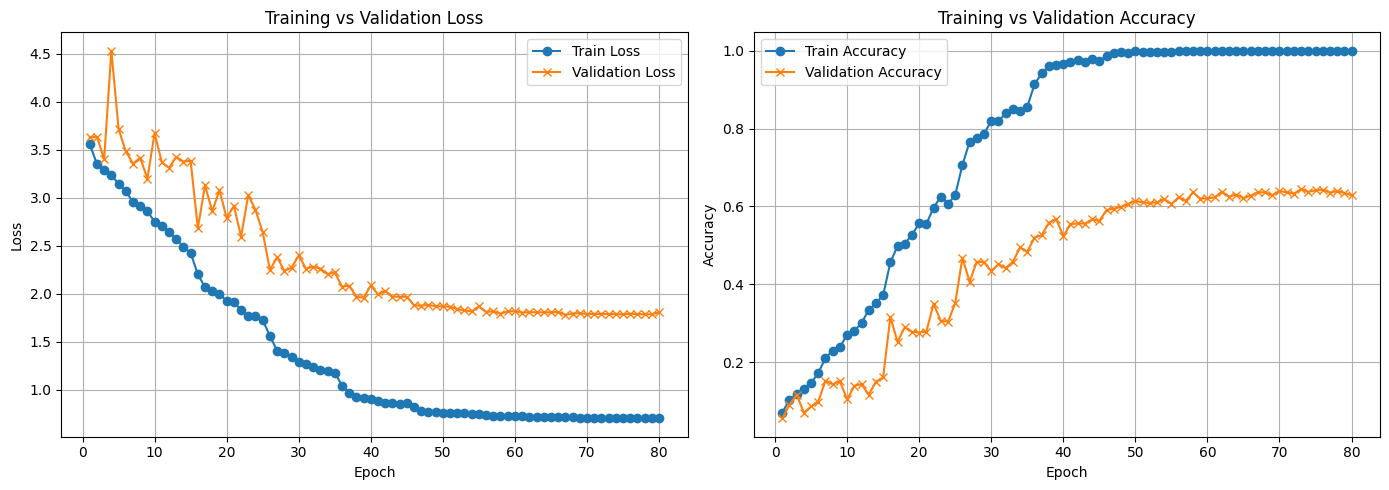

In [ ]:
plot_history(history)

Visualizing some samples:

/tmp/ipython-input-618223883.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_np = torch.tensor(mean).view(1, 1, 3).numpy()
/tmp/ipython-input-618223883.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_np = torch.tensor(std).view(1, 1, 3).numpy()


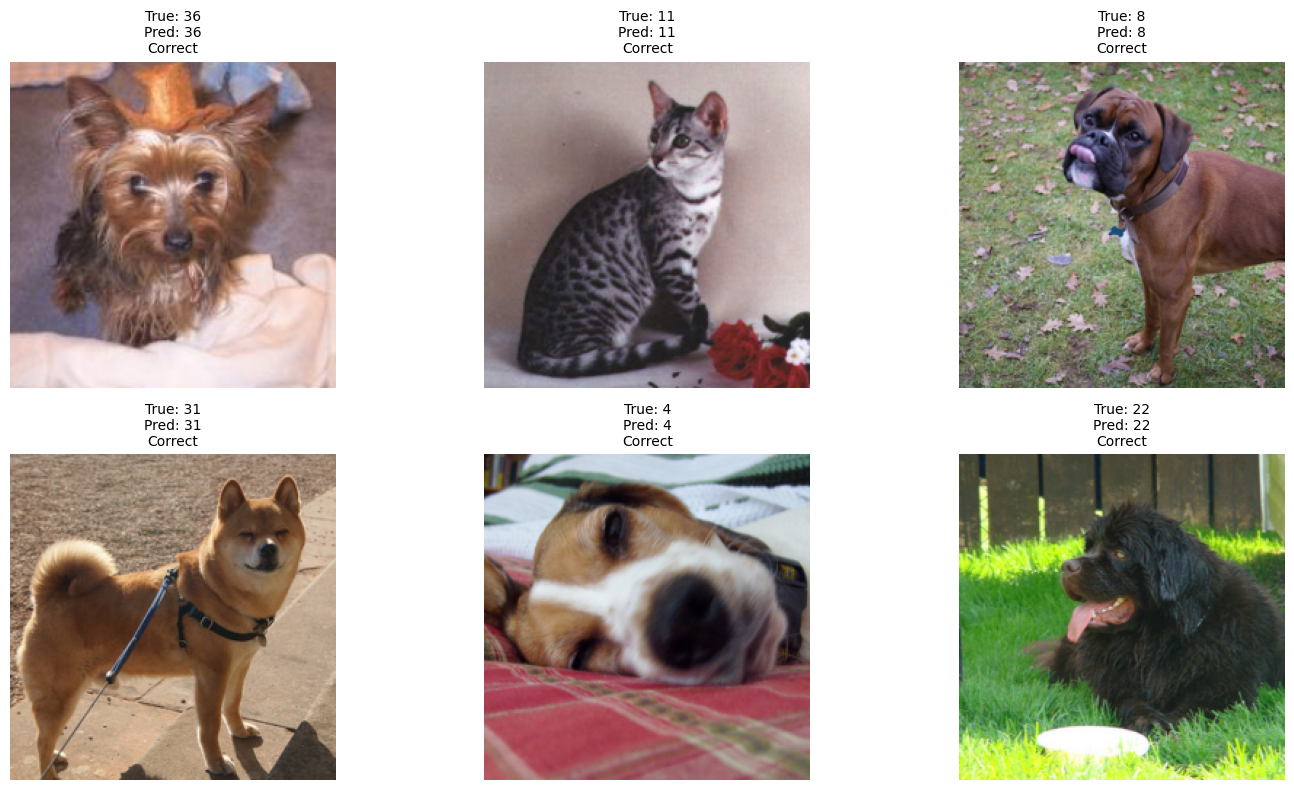

In [ ]:
# === Dataset classes
classes = list(range(test_set.get_num_classes()))

# === Number of examples to visualize
num_images = 6

# === Create grid
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

model.eval()

for i in range(num_images):
    # Get a random image
    idx = random.randint(0, len(test_set) - 1)
    img, label = test_set[idx]
    input_img = img.unsqueeze(0).to(device)

    # Prediction
    with torch.no_grad():
        output = model(input_img)
        pred_label = torch.argmax(output, dim=1).item()

    # De-normalize image for visualization
    img_np = img.permute(1, 2, 0).cpu().numpy()
    mean_np = torch.tensor(mean).view(1, 1, 3).numpy()
    std_np = torch.tensor(std).view(1, 1, 3).numpy()
    img_np = (img_np * std_np + mean_np).clip(0, 1)

    # Plot
    ax = axs[i // 3, i % 3]
    ax.imshow(img_np)
    ax.axis('off')
    ax.set_title(
        f"True: {classes[label]}\nPred: {classes[pred_label]}\n" +
        ("Correct" if label == pred_label else "Wrong"),
        fontsize=10
    )

plt.tight_layout()
plt.show()

 ## Motivating Our Design Decisions ##

In the following section, we demonstrate how each of our training choices contributed to the final performance (in terms of test accuracy). This is done by removing one component at a time from our best setup and observing the resulting performance degradation.

The following ablation settings will be considered:

 - `No Data Augmentation` — to assess the impact of image transformations during training.

 - `Smaller (Shallower) Network` — to evaluate how model depth affects accuracy.

 - `No Label Smoothing and No Weight Decay` — to measure the regularization effect of these two techniques.

 - `VGG11 instead of ResNet18` — to compare two widely used architectures with different design philosophies.

 - `No Step Scheduler and No Linear Warmup` — using a fixed learning rate instead of a dynamic schedule.

This study helps validate that the original combination of design choices led to better generalization and performance on the test set.

### No Data Augmentation ###

The following code creates the data loaders without using data augmentation.
Data augmentation helps improve generalization by introducing variability in the training images,
making the model more robust to transformations such as rotation, scaling, and lighting changes.
Removing it can lead to overfitting and reduce the model's ability to generalize.

In [ ]:
# === Temporary transform (no normalization) to compute mean/std
tmp_transform_noDA = T.Compose([
    T.Resize(cfg["resize_size"]),
    T.CenterCrop(cfg["crop_size"]),
    T.ToTensor()
])

dataset_for_stats_noDA = OxfordPetDataset(split="train", transform=tmp_transform_noDA)

# === Compute mean and std (using the already defined function)
mean_noDA, std_noDA = compute_mean_std(dataset_for_stats_noDA)
print(f"Mean (noDA): {mean_noDA.tolist()}")
print(f"Std  (noDA): {std_noDA.tolist()}")

# === Train transform (no data augmentation)
train_transform_noDA = T.Compose([
    T.Resize(cfg["resize_size"]),
    T.CenterCrop(cfg["crop_size"]),
    T.ToTensor(),
    T.Normalize(mean=mean_noDA, std=std_noDA)
])

# === Eval/test transform (same as train)
eval_transform_noDA = T.Compose([
    T.Resize(cfg["resize_size"]),
    T.CenterCrop(cfg["crop_size"]),
    T.ToTensor(),
    T.Normalize(mean=mean_noDA, std=std_noDA)
])

# === Datasets
train_set_noDA = OxfordPetDataset(split="train", transform=train_transform_noDA)
val_set_noDA   = OxfordPetDataset(split="val", transform=eval_transform_noDA)
test_set_noDA  = OxfordPetDataset(split="test", transform=eval_transform_noDA)

# === DataLoaders
train_dl_noDA = DataLoader(train_set_noDA, batch_size=cfg["batch_size"], shuffle=True)
val_dl_noDA   = DataLoader(val_set_noDA, batch_size=cfg["batch_size"])
test_dl_noDA  = DataLoader(test_set_noDA, batch_size=cfg["batch_size"])

Mean (noDA): [0.49080419540405273, 0.45249274373054504, 0.3973051905632019]
Std  (noDA): [0.227669820189476, 0.22548450529575348, 0.22633925080299377]


Creating and training the model:

In [ ]:
model_noDA = CustomResNet(num_classes=cfg["num_classes"])
output = model_noDA.to(device)
'''
print(output)
'''

optimizer = torch.optim.Adam(model_noDA.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
scheduler = get_scheduler(optimizer, cfg)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: train loss 3.439 - train acc 0.087 - val loss 3.899 - val acc 0.070 - LR 0.00120
Epoch 5: train loss 2.822 - train acc 0.261 - val loss 3.649 - val acc 0.132 - LR 0.00300
Epoch 10: train loss 2.300 - train acc 0.421 - val loss 3.572 - val acc 0.170 - LR 0.00300
Epoch 15: train loss 1.535 - train acc 0.726 - val loss 2.706 - val acc 0.303 - LR 0.00150
Epoch 20: train loss 0.925 - train acc 0.973 - val loss 2.789 - val acc 0.312 - LR 0.00150
Early stopping at epoch 24 (no improvement for 8 epochs)
Best epoch 16, best acc 0.3413
Test Accuracy: 0.2741


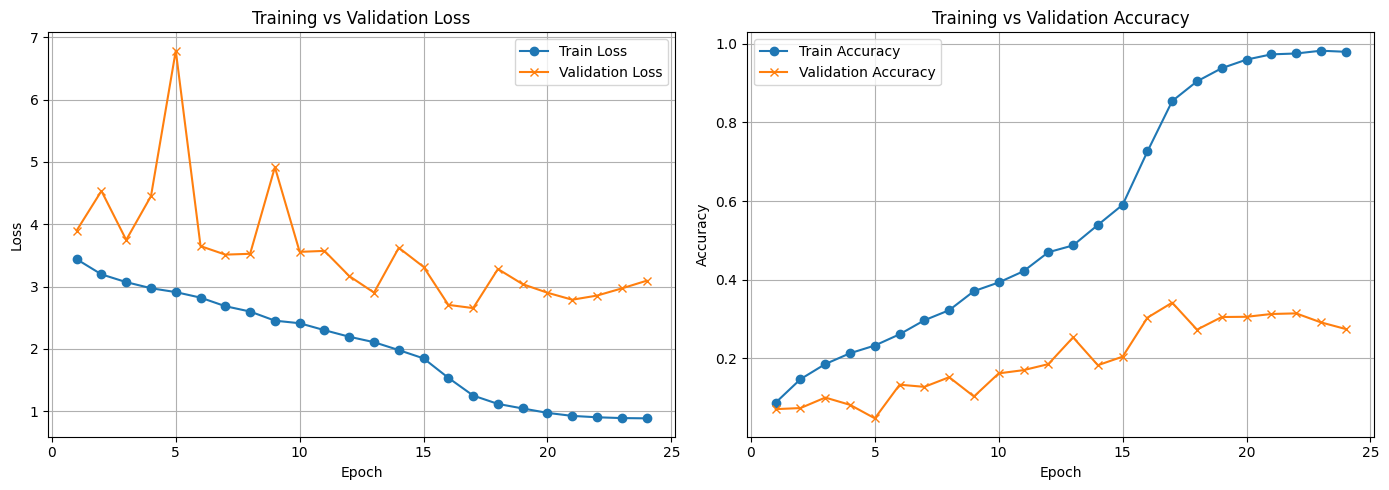

In [ ]:
# === Training ===
best_val_acc_noDA, best_params_noDA, best_epoch_noDA, history_noDA = train_loop(
    model=model_noDA,
    train_dl=train_dl_noDA,
    cfg=cfg,
    opt=optimizer,
    scheduler=scheduler,
    val_dl=val_dl_noDA
)


# === Evaluate on test set
model_noDA.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_noDA(imgs)
        test_correct += ncorrect(outputs, labels).item()
        test_samples += imgs.size(0)

test_acc = test_correct / test_samples
print(f"Test Accuracy: {test_acc:.4f}")

plot_history(history_noDA)

# === Store results under 'model_noDA' key ===
results["model_noDA"] = {
    "best_val_acc": best_val_acc_noDA,
    "best_params": best_params_noDA,
    "best_epoch": best_epoch_noDA,
    "history": history_noDA,
    "test_acc": test_acc
}



### Smaller Network ###

ShallowResNet is a simplified version of the initial ResNet with reduced depth.
Each residual layer contains only 1 BasicBlock instead of 2.
This cuts the total number of layers and parameters (~5.5M vs ~11M).
As a result, its expressive capacity is lower and the final accuracy is expected to be lower as well.
However, it is faster and easier to train, especially on smaller datasets.

In [ ]:
class ShallowResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.in_channels = 64

        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Only 1 block per layer instead of 2
        self.layer1 = self._make_layer(64, blocks=1, stride=1)
        self.layer2 = self._make_layer(128, blocks=1, stride=2)
        self.layer3 = self._make_layer(256, blocks=1, stride=2)
        self.layer4 = self._make_layer(512, blocks=1, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [BasicBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


Creating and training the model:

In [ ]:
model_SRN = ShallowResNet(num_classes=cfg["num_classes"])
output = model_SRN.to(device)
# print(output)

optimizer = torch.optim.Adam(model_SRN.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
scheduler = get_scheduler(optimizer, cfg)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: train loss 3.486 - train acc 0.085 - val loss 3.712 - val acc 0.063 - LR 0.00120
Epoch 5: train loss 2.958 - train acc 0.210 - val loss 3.490 - val acc 0.116 - LR 0.00300
Epoch 10: train loss 2.548 - train acc 0.342 - val loss 3.885 - val acc 0.175 - LR 0.00300
Epoch 15: train loss 2.065 - train acc 0.512 - val loss 2.768 - val acc 0.333 - LR 0.00150
Epoch 20: train loss 1.742 - train acc 0.641 - val loss 2.791 - val acc 0.350 - LR 0.00150
Epoch 25: train loss 1.402 - train acc 0.786 - val loss 2.252 - val acc 0.477 - LR 0.00075
Epoch 30: train loss 1.129 - train acc 0.902 - val loss 2.268 - val acc 0.462 - LR 0.00075
Epoch 35: train loss 0.967 - train acc 0.968 - val loss 2.106 - val acc 0.527 - LR 0.00038
Epoch 40: train loss 0.846 - train acc 0.992 - val loss 2.001 - val acc 0.567 - LR 0.00038
Epoch 45: train loss 0.802 - train acc 0.998 - val loss 1.926 - val acc 0.581 - LR 0.00019
Epoch 50: train loss 0.769 - train acc 0.999 - val loss 1.899 - val acc 0.593 - LR 0.00019
E

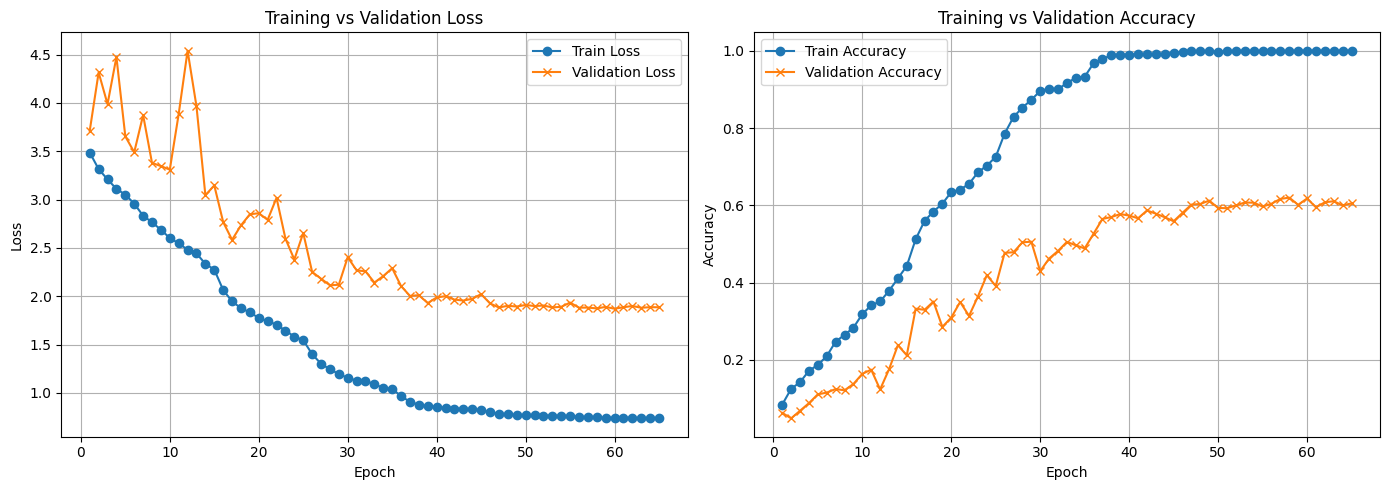

In [ ]:
# === Training ===
best_val_acc_SRN, best_params_SRN, best_epoch_SRN, history_SRN = train_loop(
    model=model_SRN,
    train_dl=train_dl,
    cfg=cfg,
    opt=optimizer,
    scheduler=scheduler,
    val_dl=val_dl
)

# === Set model to evaluation mode
model_SRN.eval()

# === Evaluate on test set
test_correct = 0
test_samples = 0

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_SRN(imgs)
        test_correct += ncorrect(outputs, labels).item()
        test_samples += imgs.size(0)

test_acc_SRN = test_correct / test_samples
print(f"Test Accuracy (ShallowResNet): {test_acc_SRN:.4f}")

plot_history(history_SRN)

# === Store results under 'model_SRN' key ===
results["model_SRN"] = {
    "best_val_acc": best_val_acc_SRN,
    "best_params": best_params_SRN,
    "best_epoch": best_epoch_SRN,
    "history": history_SRN,
    "test_acc": test_acc_SRN
}


Temporaneo... da eliminare

Test Accuracy (ShallowResNet): 0.6679


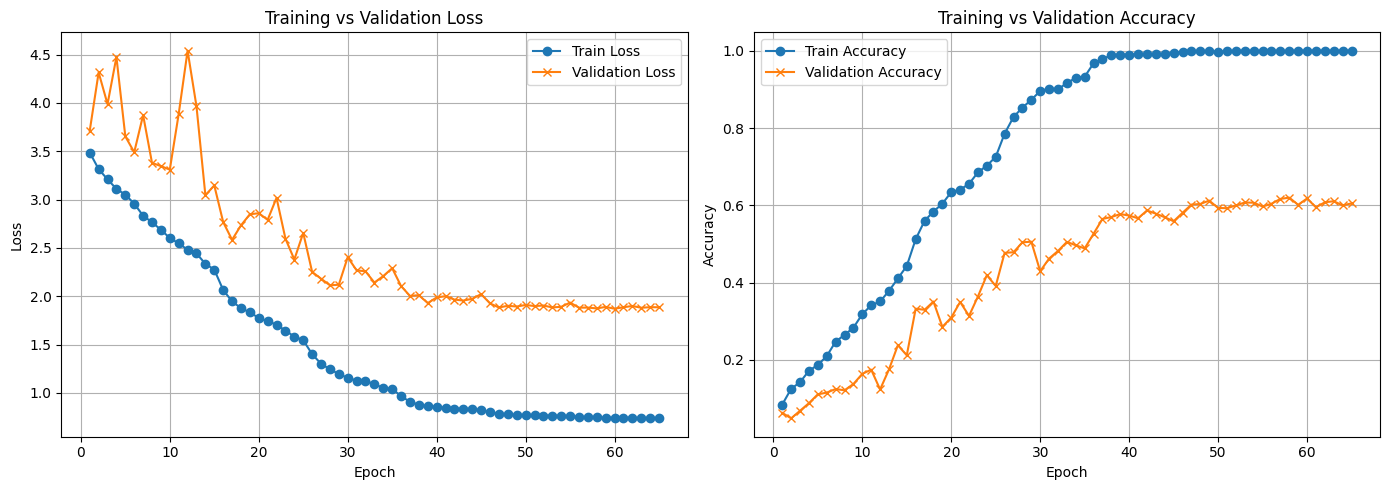

In [ ]:
# === Set model to evaluation mode
model_SRN.eval()

# === Evaluate on test set
test_correct = 0
test_samples = 0

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_SRN(imgs)
        test_correct += ncorrect(outputs, labels).item()
        test_samples += imgs.size(0)

test_acc_SRN = test_correct / test_samples
print(f"Test Accuracy (ShallowResNet): {test_acc_SRN:.4f}")

plot_history(history_SRN)

# === Store results under 'model_SRN' key ===
results["model_SRN"] = {
    "best_val_acc": best_val_acc_SRN,
    "best_params": best_params_SRN,
    "best_epoch": best_epoch_SRN,
    "history": history_SRN,
    "test_acc": test_acc_SRN
}


### No label Smoothing and No Weight Decay ###

Both of the previous techniques are used to reduce overfitting.
Label smoothing prevents the model from becoming overconfident by softening the target labels, which encourages better generalization.
Weight decay, on the other hand, penalizes large weights during optimization, effectively limiting model complexity and preventing it from fitting noise in the training data.

In [ ]:
cfg_no_ls_wd = {
    # === Pre-processing parameters ===
    "resize_size": 256,
    "crop_size": 224,

    # === Training parameters ===
    "batch_size": 128,
    "num_epochs": 200,
    "num_classes": 37,
    "label_smoothing": 0.0,    # no label smoothing

    # === Early Stopping ===
    "early_stopping_patience": 8,
    "early_stopping_delta": 1e-4,

    # === Optimizer parameters ===
    "lr": 3e-3,
    "wd": 0.0,                 # no weight decay

    # === Scheduler parameters ===
    "warmup_epochs": 5,
    "decay_epochs": 10,
    "decay_gamma": 0.5,

    # === Verbose/debug options ===
    "verbose": True
}


Using the previosue hyperparameters (where labels smoothing and weight decays are disbaled), we create and train a new model.

In [ ]:
model_no_ls_wd = CustomResNet(num_classes=cfg_no_ls_wd["num_classes"])
output = model_no_ls_wd.to(device)
#print(output)

optimizer = torch.optim.Adam(model_no_ls_wd.parameters(), lr=cfg_no_ls_wd["lr"], weight_decay=cfg_no_ls_wd["wd"])
scheduler = get_scheduler(optimizer, cfg_no_ls_wd)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: train loss 3.532 - train acc 0.070 - val loss 4.141 - val acc 0.057 - LR 0.00120
Epoch 5: train loss 2.808 - train acc 0.206 - val loss 3.178 - val acc 0.165 - LR 0.00300
Epoch 10: train loss 2.184 - train acc 0.350 - val loss 3.661 - val acc 0.148 - LR 0.00300
Epoch 15: train loss 1.496 - train acc 0.535 - val loss 2.707 - val acc 0.289 - LR 0.00150
Epoch 20: train loss 1.053 - train acc 0.671 - val loss 2.982 - val acc 0.294 - LR 0.00150
Epoch 25: train loss 0.622 - train acc 0.807 - val loss 2.233 - val acc 0.432 - LR 0.00075
Epoch 30: train loss 0.355 - train acc 0.900 - val loss 1.984 - val acc 0.503 - LR 0.00075
Epoch 35: train loss 0.199 - train acc 0.953 - val loss 1.948 - val acc 0.523 - LR 0.00038
Epoch 40: train loss 0.112 - train acc 0.978 - val loss 1.954 - val acc 0.532 - LR 0.00038
Epoch 45: train loss 0.065 - train acc 0.993 - val loss 2.023 - val acc 0.540 - LR 0.00019
Epoch 50: train loss 0.047 - train acc 0.995 - val loss 1.980 - val acc 0.546 - LR 0.00019
E

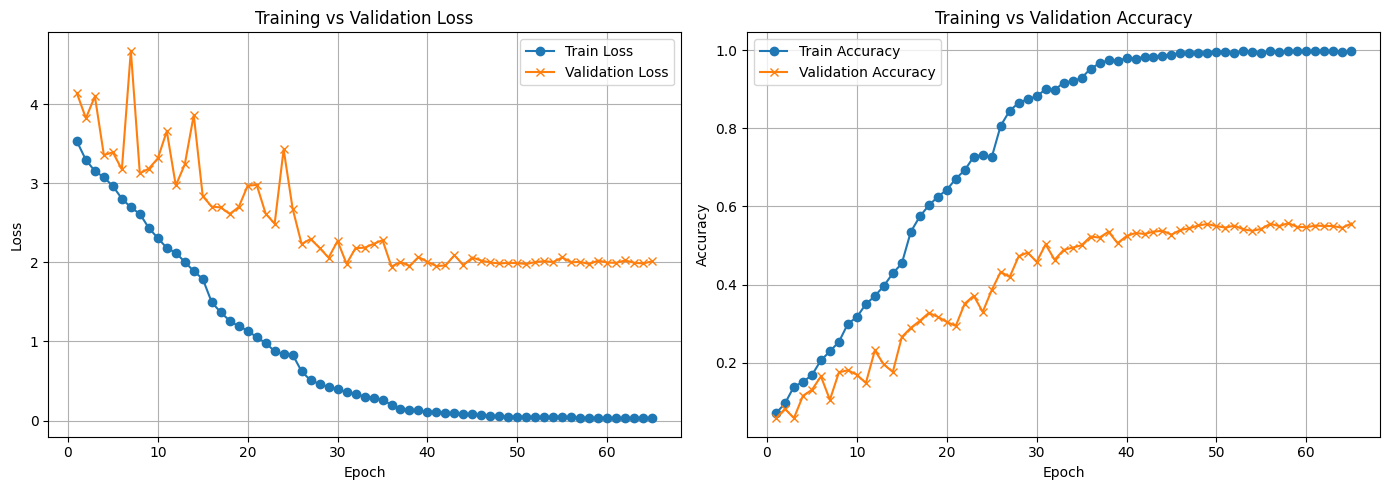

In [ ]:
# === Training ===
best_val_acc_no_ls_wd, best_params_no_ls_wd, best_epoch_no_ls_wd, history_no_ls_wd = train_loop(
    model=model_no_ls_wd,
    train_dl=train_dl,
    cfg=cfg_no_ls_wd,
    opt=optimizer,
    scheduler=scheduler,
    val_dl=val_dl
)

# === Set model to evaluation mode
model_no_ls_wd.eval()

# === Evaluate on test set
test_correct = 0
test_samples = 0

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_no_ls_wd(imgs)
        test_correct += ncorrect(outputs, labels).item()
        test_samples += imgs.size(0)

test_acc_no_ls_wd = test_correct / test_samples
print(f"Test Accuracy (no label smoothing / no weight decay): {test_acc_no_ls_wd:.4f}")

plot_history(history_no_ls_wd)

# === Store results under 'model_no_ls_wd' key ===
results["model_no_ls_wd"] = {
    "best_val_acc": best_val_acc_no_ls_wd,
    "best_params": best_params_no_ls_wd,
    "best_epoch": best_epoch_no_ls_wd,
    "history": history_no_ls_wd,
    "test_acc": test_acc_no_ls_wd
}

### VGG ###

Regarding the choice of the model, the ResNet architecture was not the only option—VGG was also a valid candidate.
However, one of the main advantages of ResNet is the use of skip connections, which make it easier for the model to learn corrections to the previous layers rather than having to learn everything from scratch.
For comparison, a VGG11 architecture—which does not use skip connections—can be implemented in PyTorch as follows:


In [ ]:
class CustomVGG11(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # assuming input 224x224
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
model_vgg11 = CustomVGG11(num_classes=cfg["num_classes"])
output = model_vgg11.to(device)
#print(output)


optimizer = torch.optim.Adam(model_vgg11.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
scheduler = get_scheduler(optimizer, cfg)

Although both ResNet18 and VGG11 are valid choices for image classification, they differ significantly in structure and parameter distribution.
While VGG11 consists mainly of convolutional layers, it ends with several large fully connected layers, which account for most of its parameters.
This makes the model much heavier and more prone to overfitting, especially on smaller datasets like Oxford-IIIT Pet.

ResNet18, in contrast, uses skip connections and a lightweight classifier head, resulting in far fewer parameters.
Its structure allows for deeper representations without a large parameter count, making it more suitable for generalization in limited data scenarios.


Here we train the VGG11 model and show the results:

In [ ]:
# === Training ===
best_val_acc_vgg11, best_params_vgg11, best_epoch_vgg11, history_vgg11 = train_loop(
    model=model_vgg11,
    train_dl=train_dl,
    cfg=cfg,
    opt=optimizer,
    scheduler=scheduler,
    val_dl=val_dl
)

# === Set model to evaluation mode
model_vgg11.eval()

# === Evaluate on test set
test_correct = 0
test_samples = 0

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_vgg11(imgs)
        test_correct += ncorrect(outputs, labels).item()
        test_samples += imgs.size(0)

test_acc_vgg11 = test_correct / test_samples
print(f"Test Accuracy (VGG11): {test_acc_vgg11:.4f}")

plot_history(history_vgg11)

# === Store results under 'model_vgg11' key ===
results["model_vgg11"] = {
    "best_val_acc": best_val_acc_vgg11,
    "best_params": best_params_vgg11,
    "best_epoch": best_epoch_vgg11,
    "history": history_vgg11,
    "test_acc": test_acc_vgg11
}


### No Step Scheduler and No Linear Warmup ###

The learning rate is one of the most important hyperparameters in training neural networks. Ideally, training should begin with a small learning rate, increase quickly during the early stages (warmup), and then progressively decrease as training progresses. In our previous setup, this behavior was implemented using a combination of linear warmup and a step scheduler.

In the absence of this scheduling strategy, the model uses a fixed initial learning rate, which may lead to suboptimal results compared to the dynamic approach.

In the code below, we train the same model as before but with a fixed learning rate strategy. It is important to note that although Adam adapts the learning rate internally for each parameter, the initial learning rate still plays a crucial role as it determines the scale of updates from the beginning. Without scheduling, this value remains constant across epochs, which may limit optimization efficiency.

In [ ]:
cfg_no_scheduler = {
    # === Pre-processing parameters ===
    "resize_size": 256,
    "crop_size": 224,

    # === Training parameters ===
    "batch_size": 128,
    "num_epochs": 200,
    "num_classes": 37,
    "label_smoothing": 0.1,

    # === Early stopping ===
    "early_stopping_patience": 8,
    "early_stopping_delta": 1e-4,

    # === Optimizer parameters (Adam) ===
    "lr": 3e-3,
    "wd": 5e-4,

    # === Scheduler disattivato ===
    "warmup_epochs": 0,   # no warmup
    "decay_epochs": None, # no step decay
    "decay_gamma": None,

    # === Verbose/debug ===
    "verbose": True
}

In [ ]:
model_no_scheduler = CustomVGG11(num_classes=cfg_no_scheduler["num_classes"])
model_no_scheduler.to(device)

optimizer = torch.optim.Adam(
    model_no_ls_wd.parameters(),
    lr=cfg_no_scheduler["lr"],
    weight_decay=cfg_no_scheduler["wd"]
)

scheduler = None  # No scheduler used with cfg_no_scheduler

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: train loss 3.611 - train acc 0.029 - val loss 3.611 - val acc 0.027 - LR 0.00300
Epoch 5: train loss 3.611 - train acc 0.029 - val loss 3.611 - val acc 0.027 - LR 0.00300
Early stopping at epoch 8 (no improvement for 8 epochs)
Best epoch 0, best acc 0.0273
Test Accuracy (no scheduler): 0.0271


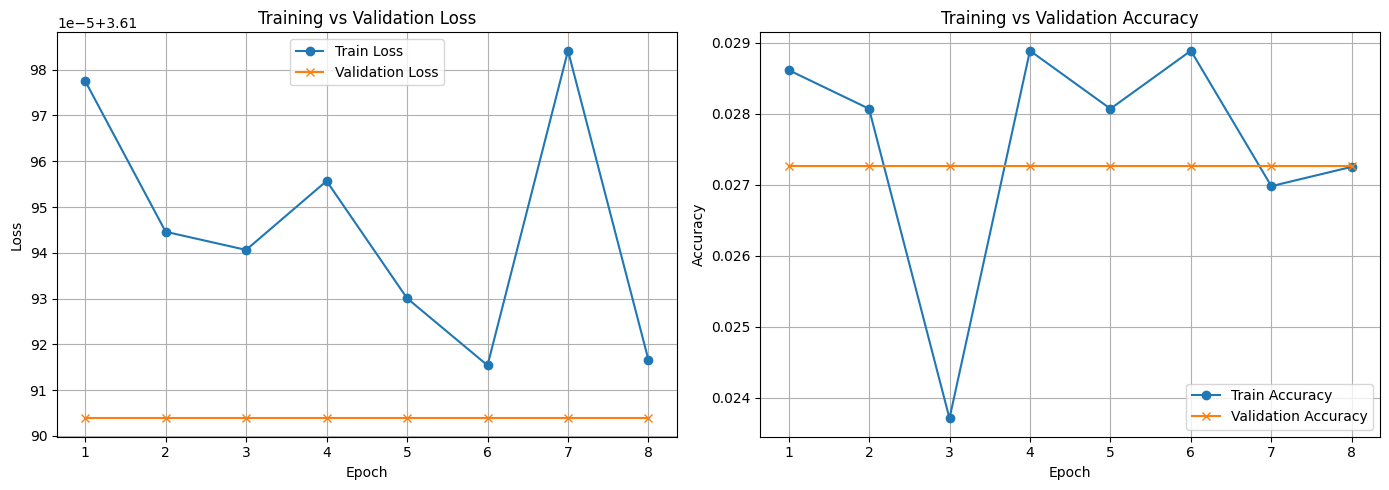

In [ ]:
# === Training ===
best_val_acc_no_scheduler, best_params_no_scheduler, best_epoch_no_scheduler, history_no_scheduler = train_loop(
    model=model_no_scheduler,
    train_dl=train_dl,
    cfg=cfg_no_scheduler,
    opt=optimizer,
    scheduler=scheduler,
    val_dl=val_dl
)

# === Set model to evaluation mode
model_no_scheduler.eval()

# === Evaluate on test set
test_correct = 0
test_samples = 0

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_no_scheduler(imgs)
        test_correct += ncorrect(outputs, labels).item()
        test_samples += imgs.size(0)

test_acc_no_scheduler = test_correct / test_samples
print(f"Test Accuracy (no scheduler): {test_acc_no_scheduler:.4f}")

plot_history(history_no_scheduler)

# === Store results under 'model_no_scheduler' key ===
results["model_no_scheduler"] = {
    "best_val_acc": best_val_acc_no_scheduler,
    "best_params": best_params_no_scheduler,
    "best_epoch": best_epoch_no_scheduler,
    "history": history_no_scheduler,
    "test_acc": test_acc_no_scheduler
}


## Final Considerations ##

The following code displays the results of the previous experiments/models,
highlighting how the first (complete) model achieved the best performance.

In [ ]:
# Convert the results dictionary to a sorted DataFrame
def results_to_dataframe(results):
    rows = []
    for model_name, data in results.items():
        rows.append({
            "Model": model_name,
            "Best Val Accuracy": round(data["best_val_acc"], 4),
            "Best Epoch": data["best_epoch"],
            "Test Accuracy": round(data["test_acc"], 4)
        })
    # Create the DataFrame and sort by test accuracy
    df = pd.DataFrame(rows)
    df = df.sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)
    return df

# Create and display the table
df_results = results_to_dataframe(results)
display(df_results)

,Model,Best Val Accuracy,Best Epoch,Test Accuracy
0,complete_model,0.6439,72,0.6728
1,model_SRN,0.6200,57,0.6679
2,model_no_ls_wd,0.5573,57,0.5899
3,model_noDA,0.3413,16,0.2741
4,model_no_scheduler,0.0273,0,0.0271


# Part 2

## 2A

### Fine-tuning a pretrained ResNet18 on ImageNet-1K (V1)
The function `get_model` loads a Resnet18.

The final layer (fc) is replaced with a new fully-connected layer to match the number of classes (in this case, 37), since the original ResNet-18 is for ImageNet (1000 classes).

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
from typing import Optional

def get_model(
        num_classes: int,
        weights: Optional[ResNet18_Weights] = None
    ) -> nn.Module:
    """Gets an image classifier based on ResNet-18.

    Args:
        num_classes: the number of classes.
        weights: pretrained weights to load into the network.
                 If None, the network is randomly initialized.

    Returns:
        The required network.
    """
    model = resnet18(weights=weights)
    # Here we override the old classifier
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## model instantiation

model_transfer = get_model(num_classes=37, weights=ResNet18_Weights.DEFAULT)
model_transfer.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Transfer Learning Approach ###
- Start with **Feature Frozen Extractor**: use pretrained features as-is, and only train the final classifier on the new task by freeezing all the layers except the final fully-connected layer
- **Fine-tuning**: unfreezing the whole network so the entire network will be updated during training.

In [ ]:
#feature frozen extractor

# === freezes all layers except the fully connected layer ===

for name, param in model_transfer.named_parameters():
    if not name.startswith("fc"):
        param.requires_grad = False

In [ ]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_transfer.parameters()),
    lr=cfg["lr"],
    weight_decay=cfg["wd"]
)

# === Scheduler ===
scheduler = get_scheduler(optimizer, cfg)

# === Training ===
best_val_acc, best_params, best_epoch, history = train_loop(
    model=model_transfer,
    train_dl=train_dl,
    cfg=cfg,
    opt=optimizer,
    scheduler=scheduler,
    val_dl=val_dl
)


save_path = "/content/drive/MyDrive/resnet18_frozen.pth"
torch.save(model_transfer.state_dict(), save_path)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: train loss 3.141 - train acc 0.249 - val loss 2.539 - val acc 0.515 - LR 0.00120
Epoch 5: train loss 1.104 - train acc 0.907 - val loss 1.252 - val acc 0.824 - LR 0.00300
Epoch 10: train loss 1.017 - train acc 0.934 - val loss 1.220 - val acc 0.841 - LR 0.00300
Epoch 15: train loss 0.966 - train acc 0.951 - val loss 1.215 - val acc 0.839 - LR 0.00150
Epoch 20: train loss 0.947 - train acc 0.958 - val loss 1.195 - val acc 0.844 - LR 0.00150
Early stopping at epoch 24 (no improvement for 8 epochs)
Best epoch 16, best acc 0.8495


In [ ]:
# === evaluation test set ===
model_transfer.eval()   # important: disable dropout/bn in training mode
test_correct = 0
test_samples = 0

all_labels = []

with torch.no_grad():  # no gradients
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_transfer(imgs)
        preds = outputs.argmax(dim=1)

        test_correct += (preds == labels).sum().item()
        test_samples += labels.size(0)

        all_labels.extend(labels.cpu().tolist())

test_acc = test_correct / test_samples
print(f"✅ Test Accuracy: {test_acc:.4f}")

✅ Test Accuracy: 0.8667


In [ ]:
#fine-tuning

# unlock all the layers


model_transfer.load_state_dict(torch.load("/content/drive/MyDrive/resnet18_frozen.pth"))
for param in model_transfer.parameters():
    param.requires_grad = True

In [ ]:
optimizer = torch.optim.Adam(model_transfer.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
scheduler = get_scheduler(optimizer, cfg)

# === Training ===
best_val_acc, best_params, best_epoch, history = train_loop(
    model=model_transfer,
    train_dl=train_dl,
    cfg=cfg,
    opt=optimizer,
    scheduler=scheduler,
    val_dl=val_dl
)


save_path = "/content/drive/MyDrive/resnet18_finetuning.pth"
torch.save(model_transfer.state_dict(), save_path)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: train loss 1.261 - train acc 0.826 - val loss 1.494 - val acc 0.768 - LR 0.00120
Epoch 5: train loss 1.302 - train acc 0.804 - val loss 1.936 - val acc 0.569 - LR 0.00300
Early stopping at epoch 8 (no improvement for 8 epochs)
Best epoch 0, best acc 0.7683


### Why does fine-tuning often perform worse?

Learning rate too high: when you unfreeze all layers, using the same learning rate as the fully connected (fc) layer can destroy the pre-trained weights.
→ Solution: use a smaller LR for the backbone (e.g., 1e-4) and a larger one for the fc layer.

Limited data: Oxford Pets has only ~7k images, so it’s easy to overfit or ruin the pre-trained weights.

Better strategy: unfreeze only the last convolutional block (layer4) plus the fc layer, instead of the entire network.

In [ ]:
# === evaluation test set  ===
model_transfer.eval()
test_correct = 0
test_samples = 0

all_labels = []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_transfer(imgs)
        preds = outputs.argmax(dim=1)

        test_correct += (preds == labels).sum().item()
        test_samples += labels.size(0)

        all_labels.extend(labels.cpu().tolist())

test_acc = test_correct / test_samples
print(f"✅ Test Accuracy: {test_acc:.4f}")

✅ Test Accuracy: 0.4745


## 2B

### Retraining with different Learing Rates

This time it applies layer-wise learning rates:ù
- lower LR for the backbone
- higher for the final layer

Goal: refining the network more delicately


In [ ]:
# === Loads the previous fine-tuned weights ===
model_transfer.load_state_dict(torch.load("/content/drive/MyDrive/resnet18_finetuning.pth"))
model_transfer.to(device)

# === Instantiate a new optimizer with differentiated LR ===
fc_params = model_transfer.fc.parameters()
backbone_params = [p for name, p in model_transfer.named_parameters() if not name.startswith("fc")]

optimizer_transfer_B = torch.optim.Adam([
    {'params': backbone_params, 'lr': 1e-4},
    {'params': fc_params, 'lr': 3e-4}
], weight_decay=cfg["wd"])

# === Instantiate a new scheduler ===
scheduler = get_scheduler(optimizer_transfer_B, cfg)

# === Update number of epochs (less espochs) ===
cfg["num_epochs"] = 200
cfg["early_stopping_patience"] = 5

# === New training with reduced LR ===
best_val_acc, best_params, best_epoch, history = train_loop(
    model=model_transfer,
    train_dl=train_dl,
    cfg=cfg,
    opt=optimizer_transfer_B,
    scheduler=scheduler,
    val_dl=val_dl
)


# === Save final model ===
save_path = "/content/drive/MyDrive/resnet18_smallerLR.pth"
torch.save(model_transfer.state_dict(), save_path)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: train loss 0.982 - train acc 0.930 - val loss 1.515 - val acc 0.720 - LR 0.00004
Epoch 5: train loss 0.790 - train acc 0.991 - val loss 1.372 - val acc 0.778 - LR 0.00010
Epoch 10: train loss 0.745 - train acc 0.998 - val loss 1.363 - val acc 0.781 - LR 0.00010
Early stopping at epoch 14 (no improvement for 5 epochs)
Best epoch 9, best acc 0.7874


In [ ]:

model_transfer.eval()
test_correct = 0
test_samples = 0

all_labels = []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_transfer(imgs)
        preds = outputs.argmax(dim=1)

        test_correct += (preds == labels).sum().item()
        test_samples += labels.size(0)

        all_labels.extend(labels.cpu().tolist())

test_acc = test_correct / test_samples
print(f"✅ Test Accuracy: {test_acc:.4f}")


✅ Test Accuracy: 0.8250


In [ ]:
#### smaller LRs ####
model_transfer.load_state_dict(torch.load("/content/drive/MyDrive/resnet18_finetuning.pth"))
model_transfer.to(device)


fc_params = model_transfer.fc.parameters()
backbone_params = [p for name, p in model_transfer.named_parameters() if not name.startswith("fc")]

optimizer_transfer_B = torch.optim.Adam([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': fc_params, 'lr': 1e-4}
], weight_decay=cfg["wd"])


scheduler = get_scheduler(optimizer_transfer_B, cfg)


cfg["num_epochs"] = 200
cfg["early_stopping_patience"] = 5


best_val_acc, best_params, best_epoch, history = train_loop(
    model=model_transfer,
    train_dl=train_dl,
    cfg=cfg,
    opt=optimizer_transfer_B,
    scheduler=scheduler,
    val_dl=val_dl
)


model_transfer.load_state_dict(best_params)
model_transfer.eval()



save_path = "/content/drive/MyDrive/resnet18_smallerLR2.pth"
torch.save(model_transfer.state_dict(), save_path)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: train loss 1.044 - train acc 0.900 - val loss 1.636 - val acc 0.682 - LR 0.00000
Epoch 5: train loss 0.900 - train acc 0.960 - val loss 1.464 - val acc 0.730 - LR 0.00001
Epoch 10: train loss 0.853 - train acc 0.973 - val loss 1.425 - val acc 0.744 - LR 0.00001
Epoch 15: train loss 0.828 - train acc 0.980 - val loss 1.400 - val acc 0.756 - LR 0.00001
Epoch 20: train loss 0.816 - train acc 0.990 - val loss 1.395 - val acc 0.760 - LR 0.00001
Epoch 25: train loss 0.810 - train acc 0.987 - val loss 1.392 - val acc 0.763 - LR 0.00000
Epoch 30: train loss 0.803 - train acc 0.990 - val loss 1.387 - val acc 0.767 - LR 0.00000
Epoch 35: train loss 0.803 - train acc 0.987 - val loss 1.384 - val acc 0.768 - LR 0.00000
Early stopping at epoch 38 (no improvement for 5 epochs)
Best epoch 33, best acc 0.7726


In [ ]:

model_transfer.eval()
test_correct = 0
test_samples = 0

all_labels = []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_transfer(imgs)
        preds = outputs.argmax(dim=1)

        test_correct += (preds == labels).sum().item()
        test_samples += labels.size(0)

        all_labels.extend(labels.cpu().tolist())

test_acc = test_correct / test_samples
print(f"✅ Test Accuracy: {test_acc:.4f}")

✅ Test Accuracy: 0.7979


### Final Training with Data Augmentation + Layer-wise LR + Warmup

Includes heavy data augmentation (random crop, flip, affine, jitter, erasing).

Model definition includes Dropout(0.5) before final classifier.

In [ ]:
mean = [0.491, 0.452, 0.397]
std  = [0.228, 0.225, 0.226]

# ==== Augmentations ====
train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
    T.RandomErasing(p=0.25)
])

eval_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# ==== Dataset & Loader ====
train_set = OxfordPetDataset(split="train", transform=train_transform)
val_set   = OxfordPetDataset(split="val", transform=eval_transform)
test_set  = OxfordPetDataset(split="test", transform=eval_transform)

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
val_dl   = DataLoader(val_set, batch_size=64)
test_dl  = DataLoader(test_set, batch_size=64)

# ==== Model ====
def get_model(num_classes):
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, num_classes)
    )
    return model

model_transfer = get_model(num_classes=37)
model_transfer.to(device)

# ==== Layer-wise LR ====
fc_params = list(model_transfer.fc.parameters())
backbone_params = [p for name, p in model_transfer.named_parameters() if not name.startswith("fc")]

optimizer_transfer_B = torch.optim.Adam([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': fc_params, 'lr': 1e-4},
], weight_decay=5e-4)

# ==== Scheduler: warmup + decay ====
def get_scheduler(optimizer, warmup_epochs=5, decay_epochs=10, decay_gamma=0.5):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        else:
            return decay_gamma ** ((epoch - warmup_epochs) // decay_epochs)
    return LambdaLR(optimizer, lr_lambda)

scheduler = get_scheduler(optimizer_transfer_B)

# ==== Config training ====
cfg["num_epochs"] = 200
cfg["early_stopping_patience"] = 8
cfg["early_stopping_delta"] = 1e-4
cfg["verbose"] = True

# ==== Training ====
best_val_acc, best_params, best_epoch, history = train_loop(
    model=model_transfer,
    train_dl=train_dl,
    val_dl=val_dl,
    cfg=cfg,
    opt=optimizer_transfer_B,
    scheduler=scheduler,
)


# ==== Saving ====
save_path = "/content/drive/MyDrive/resnet18_final_tuned.pth"
torch.save(best_params, save_path)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: train loss 3.948 - train acc 0.029 - val loss 3.675 - val acc 0.034 - LR 0.00000
Epoch 5: train loss 2.265 - train acc 0.516 - val loss 1.903 - val acc 0.735 - LR 0.00001
Epoch 10: train loss 1.482 - train acc 0.767 - val loss 1.346 - val acc 0.824 - LR 0.00001
Epoch 15: train loss 1.283 - train acc 0.829 - val loss 1.216 - val acc 0.848 - LR 0.00001
Epoch 20: train loss 1.221 - train acc 0.859 - val loss 1.184 - val acc 0.853 - LR 0.00001
Epoch 25: train loss 1.169 - train acc 0.870 - val loss 1.163 - val acc 0.860 - LR 0.00000
Epoch 30: train loss 1.142 - train acc 0.885 - val loss 1.150 - val acc 0.865 - LR 0.00000
Epoch 35: train loss 1.129 - train acc 0.884 - val loss 1.142 - val acc 0.858 - LR 0.00000
Epoch 40: train loss 1.105 - train acc 0.897 - val loss 1.138 - val acc 0.863 - LR 0.00000
Epoch 45: train loss 1.103 - train acc 0.894 - val loss 1.138 - val acc 0.860 - LR 0.00000
Early stopping at epoch 46 (no improvement for 8 epochs)
Best epoch 38, best acc 0.8664


Compute accuracy on the test set

In [ ]:

model_transfer.eval()
test_correct = 0
test_samples = 0

all_labels = []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model_transfer(imgs)
        preds = outputs.argmax(dim=1)

        test_correct += (preds == labels).sum().item()
        test_samples += labels.size(0)

        all_labels.extend(labels.cpu().tolist())

test_acc = test_correct / test_samples
print(f"✅ Test Accuracy: {test_acc:.4f}")

✅ Test Accuracy: 0.8846


### 🔧 Next possible steps

If you want to push performance further:

Partial unfreezing: instead of the whole network, keep only layer4 + fc trainable. This can sometimes boost accuracy by 1–2 percentage points on medium-sized datasets.

Finer LR tuning: using a backbone LR of 3e-5 and an fc LR of 3e-4 is often a good trade-off.

Label smoothing: adding a smoothing term to cross-entropy (e.g., eps = 0.1) improves robustness when classes are visually similar.

Mixup/CutMix: these augmentations can further enhance generalization, though they make model interpretability slightly harder.

In [ ]:
# ==== partial unfreeze model ====
def get_model_partial_unfreeze(num_classes):
    model = resnet18(weights=ResNet18_Weights.DEFAULT)

    # freeze all initial layers
    for param in model.parameters():
        param.requires_grad = False

    # Wnable layer4 (last residual block) + fully connected
    for param in model.layer4.parameters():
        param.requires_grad = True

    # replace final classifier
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, num_classes)
    )
    return model

model_transfer = get_model_partial_unfreeze(num_classes=37)
model_transfer.to(device)

# ==== Layer-wise LR ====
fc_params = list(model_transfer.fc.parameters())
layer4_params = list(model_transfer.layer4.parameters())
backbone_params = [p for name, p in model_transfer.named_parameters()
                   if not name.startswith("fc") and not name.startswith("layer4")]

optimizer_transfer_partial = torch.optim.Adam([
    {'params': backbone_params, 'lr': 1e-6},   # resto congelato quasi del tutto
    {'params': layer4_params, 'lr': 3e-5},     # ultimo blocco un po' più veloce
    {'params': fc_params, 'lr': 3e-4},         # testa molto veloce
], weight_decay=5e-4)

# ==== Scheduler (warmup + decay) ====
scheduler = get_scheduler(optimizer_transfer_partial)

# ==== Config training ====
cfg["num_epochs"] = 200
cfg["early_stopping_patience"] = 10
cfg["early_stopping_delta"] = 1e-4
cfg["verbose"] = True

# ==== Training ====
best_val_acc, best_params, best_epoch, history = train_loop(
    model=model_transfer,
    train_dl=train_dl,
    val_dl=val_dl,
    cfg=cfg,
    opt=optimizer_transfer_partial,
    scheduler=scheduler,
)

# ==== restore best params ====
model_transfer.load_state_dict(best_params)
model_transfer.eval()

# ==== Test set ====
test_correct, test_samples = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model_transfer(imgs)
        preds = outputs.argmax(dim=1)

        test_correct += (preds == labels).sum().item()
        test_samples += labels.size(0)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_acc = test_correct / test_samples
print(f"✅ Test Accuracy (partial unfreeze): {test_acc:.4f}")

# ==== Saving ====
save_path = "/content/drive/MyDrive/resnet18_partial_unfreeze.pth"
torch.save(best_params, save_path)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: train loss 3.871 - train acc 0.037 - val loss 3.432 - val acc 0.115 - LR 0.00000
Epoch 5: train loss 1.528 - train acc 0.739 - val loss 1.330 - val acc 0.817 - LR 0.00000
Epoch 10: train loss 1.209 - train acc 0.856 - val loss 1.179 - val acc 0.847 - LR 0.00000
Epoch 15: train loss 1.113 - train acc 0.892 - val loss 1.147 - val acc 0.863 - LR 0.00000
Epoch 20: train loss 1.069 - train acc 0.908 - val loss 1.145 - val acc 0.859 - LR 0.00000
Epoch 25: train loss 1.044 - train acc 0.919 - val loss 1.136 - val acc 0.864 - LR 0.00000
Epoch 30: train loss 1.028 - train acc 0.925 - val loss 1.131 - val acc 0.866 - LR 0.00000
Epoch 35: train loss 1.013 - train acc 0.931 - val loss 1.127 - val acc 0.863 - LR 0.00000
Early stopping at epoch 36 (no improvement for 10 epochs)
Best epoch 26, best acc 0.8659
✅ Test Accuracy (partial unfreeze): 0.8873
